In [ ]:
import gym
import random
import tflearn as tf
import numpy as np
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from statistics import mean, median
from collections import Counter

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
LR = 1e-3
env = gym.make('CartPole-v0')
env.reset()
max_goal= 500
score_requirement= 50
initial_games = 10000


/home/ankit/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
def some_random_games():
    for episode in range(50):
        env.reset()
        for t in range(max_goal):
            env.render()
            action = env.action_space.sample()     #  provided in gym
            observation, reward, done, info = env.step(action)
            if done:
                break

In [4]:
#some_random_games()

In [5]:
def initial_population():
    training_data = []
    scores = []
    accepted_scores = [] 
    for _ in range(initial_games):
        score = 0
        game_memory = []
        prev_observation = []
        for _ in range(max_goal):
#             env.render()
            action = random.randrange(0,2)
            observation, reward, done, info = env.step(action)
            if len(prev_observation)>0:
                game_memory.append([prev_observation,action])

            prev_observation = observation
            score+= reward
            if done:
                break
        if score>=score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                if data[1]==1:
                    output = [0,1]
                elif data[1] ==0:
                    output = [1,0]
                training_data.append([data[0],output])
                
                
        env.reset()
        scores.append(score)
    training_data_save = np.array(training_data)
    np.save('saved.npy', training_data_save)
    print('Average accepted score:', mean(accepted_scores))
    print('Median accepted score :', median(accepted_scores))
    print(Counter(accepted_scores))
    
    return training_data

In [6]:
# initial_population()

In [3]:
def neural_network_model(input_size):
    network = input_data(shape=[None,input_size,1],name  = 'input')
    
    network = fully_connected(network,128,activation = 'relu')
    network = dropout(network,0.8)
    
    network = fully_connected(network,256,activation = 'relu')
    network = dropout(network,0.8)
    
    network = fully_connected(network,512,activation = 'relu')
    network = dropout(network,0.8)
    
    network = fully_connected(network,256,activation = 'relu')
    network = dropout(network,0.8)
    
    network = fully_connected(network,128,activation = 'relu')
    network = dropout(network,0.8)
    
    network = fully_connected(network,2,activation = 'softmax')
    network = regression(network,optimizer = 'adam', learning_rate=LR, 
                         loss='categorical_crossentropy',name='targets')
    
    model =  tf.DNN(network,tensorboard_dir= 'log1')
    
    return model

def train_model(training_data):
    X = np.array([i[0] for i in training_data]).reshape(-1,len(training_data[0][0]),1)
    y = [i[1] for i in training_data]
    
    model =neural_network_model(input_size= len(X[0]))
    model.load('cartpole0BestScore.model',weights_only=True)

        
    model.fit({'input':X},{'targets':y},n_epoch=3,snapshot_step=500,show_metric =True,run_id = 'openai')
    
    return model
    
    
    
    

In [4]:
# training_data = initial_population()
training_data = np.load('saved.npy')

In [5]:
model= train_model(training_data)
# model= model.load('cartpole0.model')

Training Step: 4599  | total loss: 0.68099 | time: 24.000s
| Adam | epoch: 004 | loss: 0.68099 - acc: 0.5655 -- iter: 73536/73539
Training Step: 4600  | total loss: 0.68259 | time: 24.022s
| Adam | epoch: 004 | loss: 0.68259 - acc: 0.5699 -- iter: 73539/73539
--


In [10]:
# model.save('cartpole0.model')

In [11]:
# model.load('cartpole0.model')

In [7]:
scores=[]
choices =[]

for each_game in range(200):
    score=0
    game_memory=[]
    prev_obs = []
    env.reset()
    for _ in range(max_goal):
        env.render()
        if len(prev_obs)==0:
            action = random.randrange(0,2)
        else:
            action = np.argmax(model.predict(prev_obs.reshape(-1,len(prev_obs),1))[0])
        choices.append(action)
        
        new_observation,reward,done,info = env.step(action)
        prev_obs = new_observation
        game_memory.append([new_observation,action])
        score += reward
        if done:
            break
    scores.append(score)
print('Average Score', sum(scores)/len(scores))
print('Choices1:{}','Choice 2: {}'.format(choices.count(1)/len(choices)),choices.count(0)/len(choices))



KeyboardInterrupt: 

Text(0, 0.5, 'average score')

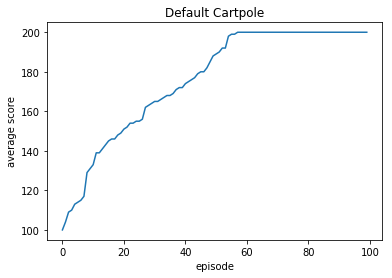

In [15]:
final_scores = np.sort(scores)

import matplotlib.pyplot as plt
plt.plot(np.sort(final_scores))
plt.title('Default Cartpole')
plt.xlabel("episode")
plt.ylabel('average score')

In [16]:
np.save('savev1raw1.npy', final_scores)
